# Transformers

This tutorial on Transformers is based on the youtube video by Andrej Karpathy here:

https://www.youtube.com/watch?v=kCc8FmEb1nY

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
torch.manual_seed(42)

## Dataset 1

We are going to use the [wikipron](https://github.com/CUNY-CL/wikipron) dataset `v1.3.0` which contains a database of over 3M word/pronunciation pairs from 251 languages scraped from [Wiktionary](https://en.wiktionary.org/wiki/Wiktionary:Main_Page).

The pronunciations are in the [International Phonetic Alphabet](https://en.wikipedia.org/wiki/International_Phonetic_Alphabet) (IPA) format.

The dataset is described in detail in the following paper:

> Jackson L. Lee, Lucas F.E. Ashby, M. Elizabeth Garza, Yeonju Lee-Sikka, Sean Miller, Alan Wong, Arya D. McCarthy, and Kyle Gorman (2020). [Massively multilingual pronunciation mining with WikiPron](https://www.aclweb.org/anthology/2020.lrec-1.521/). In Proceedings of the 12th Language Resources and Evaluation Conference, pages 4223-4228.

The github repo contains more up to date scrape of data from Wiktionary.

In [271]:
import re
import random
from zipfile import ZipFile, is_zipfile
from collections import defaultdict
random.seed(42)

datafile = 'wikipron-data-1.3.0.zip'
constraints = ['narrow', 'latn']
data = defaultdict(list)

if is_zipfile(datafile):
    with ZipFile(datafile) as wpzip:
        for filename in wpzip.namelist():
            features = filename.split('_')
            lang = features[0]
            matches = [ True if re.search(c, filename) else False for c in constraints ]
            if all(matches):
                print(lang, filename)
                with wpzip.open(filename, 'r') as fh:
                    data[lang] += [ s.decode('utf8').strip() for s in fh.readlines() ]

afr afr_latn_narrow.tsv
ang ang_latn_narrow.tsv
apw apw_latn_narrow.tsv
ast ast_latn_narrow.tsv
aze aze_latn_narrow.tsv
aze aze_latn_narrow_filtered.tsv
ces ces_latn_narrow.tsv
cor cor_latn_narrow.tsv
cym cym_latn_nw_narrow.tsv
cym cym_latn_sw_narrow.tsv
dan dan_latn_narrow.tsv
deu deu_latn_narrow.tsv
dsb dsb_latn_narrow.tsv
eng eng_latn_uk_narrow.tsv
eng eng_latn_us_narrow.tsv
epo epo_latn_narrow.tsv
eus eus_latn_narrow.tsv
fao fao_latn_narrow.tsv
fin fin_latn_narrow.tsv
fra fra_latn_narrow.tsv
gle gle_latn_narrow.tsv
glg glg_latn_narrow.tsv
glv glv_latn_narrow.tsv
hau hau_latn_narrow.tsv
haw haw_latn_narrow.tsv
hun hun_latn_narrow.tsv
hun hun_latn_narrow_filtered.tsv
huu huu_latn_narrow.tsv
iba iba_latn_narrow.tsv
ilo ilo_latn_narrow.tsv
ind ind_latn_narrow.tsv
isl isl_latn_narrow.tsv
lat lat_latn_clas_narrow.tsv
lat lat_latn_eccl_narrow.tsv
lav lav_latn_narrow.tsv
lav lav_latn_narrow_filtered.tsv
lim lim_latn_narrow.tsv
lit lit_latn_narrow.tsv
lmo lmo_latn_narrow.tsv
lmy lmy_latn_na

Let's check the format of the data for English. Each language is stored as a separate key in the `data` dictionary.

In [272]:
print("\n".join(data['eng'][:20]))

'em	m̩
'em	ə m
'em	ɛ m
'em	ɪ m
'll	l̩
'll	ə l
'll	ɫ̩
'll	ɯ
'll	ʊ
'n'	n̩
'n'	ə n
'rales	ɹ ɑː l i z
aa	ɑː ʔ ɑː
abear	ə b ɛː
accend	æ k s ɛ n d
accommodate	ə kʰ ɒ m ə d e ɪ t
accommodator	ə k ɒ m ə d e ɪ t ə
accreditation	ə k ɹ ɛ d ɪ t e ɪ ʃ ə n
acknowledge	ə k n ɒ l ɨ̞ d͡ʒ
acknowledge	ə ɡ n ɒ l ɨ̞ d͡ʒ


In [273]:
dataset = []
start = '<|starttext|>'
to_ipa = '<|to_ipa|>'
endoftext = '<|endoftext|>'
padtoken = '<|padtoken|>'
languages = ['eng']
#languages = data.keys()  # data.keys() for all languages

for lang in languages:
    for i in data[lang]:
        (source, target) = i.split('\t')
        dataset.append([start] + list(source) + [to_ipa] + target.split(' ') + [endoftext])

In [274]:
print(dataset[:5])

[['<|starttext|>', "'", 'e', 'm', '<|to_ipa|>', 'm̩', '<|endoftext|>'], ['<|starttext|>', "'", 'e', 'm', '<|to_ipa|>', 'ə', 'm', '<|endoftext|>'], ['<|starttext|>', "'", 'e', 'm', '<|to_ipa|>', 'ɛ', 'm', '<|endoftext|>'], ['<|starttext|>', "'", 'e', 'm', '<|to_ipa|>', 'ɪ', 'm', '<|endoftext|>'], ['<|starttext|>', "'", 'l', 'l', '<|to_ipa|>', 'l̩', '<|endoftext|>']]


## Dataset 2

The second dataset is the names corpus we used before to train an n-gram language model and n-gram MLP model

In [4]:
words = open('names.txt', 'r').read().splitlines()
words = [w.strip() for w in words] # remove any space chars
words = [w for w in words if w] # remove any empty strings

Let's collect the vocabulary from the dataset. This will be used to encode each example in the dataset to a tensor and when we get output from our model we can decode it back to the vocabulary.

In [5]:
start = '<|starttext|>'
endoftext = '<|endoftext|>'
padtoken = '<|padtoken|>'

vocab = [start] + [endoftext] + [padtoken] + sorted(list({ c for ex in words for c in ex }))
vocab_size = len(vocab)
print(''.join(vocab))
print(f'{vocab_size=}')

<|starttext|><|endoftext|><|padtoken|>abcdefghijklmnopqrstuvwxyz
vocab_size=29


First we create a mapping `stoi` from the vocabulary to integers, and vice versa `itos`.

In [6]:
stoi = { ch:i for i, ch in enumerate(vocab) }
itos = { i:ch for i, ch in enumerate(vocab) }

Then we use this mapping to create `encode` and `decode` functions from raw input to integers and back.

In [7]:
encode = lambda input: [stoi[c] for c in input]
decode = lambda ints: [itos[i] for i in ints]

In [8]:
dataset = []
for w in words:
    dataset.append([start] + list(w) + [endoftext] + [padtoken])

In [9]:
print(encode(dataset[0]))

[0, 7, 15, 15, 3, 1, 2]


In [10]:
print(decode(encode(dataset[0])))

['<|starttext|>', 'e', 'm', 'm', 'a', '<|endoftext|>', '<|padtoken|>']


In [11]:
def get_longest(dataset):
    max_len = 0
    longest = None
    idx = None
    for i, ex in enumerate(dataset):
        if len(ex) > max_len:
            idx = i
            max_len = len(ex)
            longest = ex
    return(idx, max_len, longest)

(longest_idx, max_len, longest) = get_longest(dataset)

In [12]:
print(longest_idx, max_len, longest)

31441 18 ['<|starttext|>', 'm', 'u', 'h', 'a', 'm', 'm', 'a', 'd', 'i', 'b', 'r', 'a', 'h', 'i', 'm', '<|endoftext|>', '<|padtoken|>']


We pad each example in the dataset to be the same as the longest example. This will ensure we can have same length tensors in each batch of training. At the same time we will convert the dataset using the `encode` function to a torch `tensor` object. 

In [13]:
data = []
for ex in dataset:
    pad_ex = ex + ([padtoken] * (max_len - len(ex)))
    data.append(torch.tensor(encode(pad_ex), dtype=torch.long))
print(data[:10])

[tensor([ 0,  7, 15, 15,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0, 17, 14, 11, 24, 11,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0,  3, 24,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0, 11, 21,  3,  4,  7, 14, 14,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0, 21, 17, 18, 10, 11,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0,  5, 10,  3, 20, 14, 17, 22, 22,  7,  1,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0, 15, 11,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0,  3, 15,  7, 14, 11,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0, 10,  3, 20, 18,  7, 20,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2]), tensor([ 0,  7, 24,  7, 14, 27, 16,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])]


In [14]:
print(data[380])

tensor([ 0,  3, 15,  3, 20, 11,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2])


The number of training examples is:

In [15]:
print(len(data))

32033


Next step is to split up the dataset into a training set and validation set.

In [16]:
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

We set the `block_size` to `max_len-2` because we have added a endoftext and padtoken to each example.

In [17]:
block_size = max_len-2
print(data[longest_idx][0:block_size])
print(data[longest_idx][1:block_size+1])

tensor([ 0, 15, 23, 10,  3, 15, 15,  3,  6, 11,  4, 20,  3, 10, 11, 15])
tensor([15, 23, 10,  3, 15, 15,  3,  6, 11,  4, 20,  3, 10, 11, 15,  1])


Check that the input and output tensor lengths are correct by checking on the longest example in the dataset. `x` is the input tensor and `y` is the tensor with the output for each prefix of the input.

In [18]:
x = torch.stack([data[longest_idx][0:block_size]])
y = torch.stack([data[longest_idx][1:block_size+1]])
print(x, x.size())
print(y, y.size())

tensor([[ 0, 15, 23, 10,  3, 15, 15,  3,  6, 11,  4, 20,  3, 10, 11, 15]]) torch.Size([1, 16])
tensor([[15, 23, 10,  3, 15, 15,  3,  6, 11,  4, 20,  3, 10, 11, 15,  1]]) torch.Size([1, 16])


In [20]:
def get_batch(split, block_size, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data), (batch_size,))
    x = torch.stack([data[i][0:block_size] for i in ix])
    y = torch.stack([data[i][1:block_size+1] for i in ix])
    return x, y

block_size = max_len-2
batch_size = 4
xb, yb = get_batch('train', block_size, batch_size)
print(xb, xb.size())
print(yb, yb.size())

tensor([[ 0, 24, 11, 17, 14,  7, 22, 22,  7,  1,  2,  2,  2,  2,  2,  2],
        [ 0, 15, 17, 26,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 22,  7, 20,  3, 10,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 11, 14, 27,  3, 16, 16,  3,  1,  2,  2,  2,  2,  2,  2,  2]]) torch.Size([4, 16])
tensor([[24, 11, 17, 14,  7, 22, 22,  7,  1,  2,  2,  2,  2,  2,  2,  2],
        [15, 17, 26,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [22,  7, 20,  3, 10,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [11, 14, 27,  3, 16, 16,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2]]) torch.Size([4, 16])


In [21]:
for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b, t]
        print(f'when input is {context.tolist()} the target is: {target}')

when input is [0] the target is: 24
when input is [0, 24] the target is: 11
when input is [0, 24, 11] the target is: 17
when input is [0, 24, 11, 17] the target is: 14
when input is [0, 24, 11, 17, 14] the target is: 7
when input is [0, 24, 11, 17, 14, 7] the target is: 22
when input is [0, 24, 11, 17, 14, 7, 22] the target is: 22
when input is [0, 24, 11, 17, 14, 7, 22, 22] the target is: 7
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7] the target is: 1
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1] the target is: 2
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1, 2] the target is: 2
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1, 2, 2] the target is: 2
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1, 2, 2, 2] the target is: 2
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1, 2, 2, 2, 2] the target is: 2
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1, 2, 2, 2, 2, 2] the target is: 2
when input is [0, 24, 11, 17, 14, 7, 22, 22, 7, 1, 2, 2, 2, 2, 2, 2] the target is: 2
w

## Bigram Language Model

Let us define $B$ as the `batch_size`, $T$ is the time dimension aka the length of the input sequence, and $C$ is the so-called channel size which is defined to be the `vocab_size` (the output dimension).

The bigram language model (LM) is defined here to be a very simple LM where we use an embedding for the current token which is define to be size `vocab_size` to predict the next token.

In [22]:
class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token has an embedding which predicts the next token
        self.vocab_size = vocab_size
        self.bigram = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets):
        # B: batch_size
        # T: time
        # C: channel_size aka vocab_size
        # idx and targets are (B,T) size tensors
        logits = self.bigram(idx) # returns (B,T,C) tensor
        B, T, C = logits.shape
        logits = logits.view(B*T, self.vocab_size)
        loss = F.cross_entropy(logits, targets.view(B*T))
        #print(logits.view(B*T, self.vocab_size).shape)
        #print(targets.view(B*T).shape)
        # note that this is the same as the following using Pytorch type coercion:
        # loss = F.cross_entropy(logits.view(-1, self.vocab_size), targets.view(-1))
        return logits, loss

In [23]:
print(f'{vocab_size=}')

vocab_size=29


In [24]:
model1 = BigramLM(vocab_size)
out, loss = model1(xb, yb)
print(out, out.shape)
print(loss)

tensor([[ 1.7878, -0.4780, -0.2429,  ...,  0.8034, -0.6216, -0.5920],
        [-1.5256,  1.2538, -0.6843,  ...,  0.0784,  0.2236,  0.1113],
        [ 0.0561, -0.4560, -0.0619,  ..., -0.7155,  0.0762, -0.2127],
        ...,
        [-1.0759,  0.5357,  1.1754,  ...,  0.4048, -1.3543, -0.4976],
        [-1.0759,  0.5357,  1.1754,  ...,  0.4048, -1.3543, -0.4976],
        [-1.0759,  0.5357,  1.1754,  ...,  0.4048, -1.3543, -0.4976]],
       grad_fn=<ViewBackward0>) torch.Size([64, 29])
tensor(3.4624, grad_fn=<NllLossBackward0>)


### Loss function

We expect loss to be $\log_e(\frac{1}{vocabsize})$

In [25]:
print(torch.log(torch.tensor(1/vocab_size)))

tensor(-3.3673)


### Add a generator function

In [26]:
class BigramLM(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # each token has an embedding which predicts the next token
        self.vocab_size = vocab_size
        self.bigram = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: time
        # C: channel_size aka vocab_size
        # idx is a (B,T) size tensor
        return self.bigram(idx) # returns (B,T,C) tensor

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            logits = self(idx) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [27]:
model1 = BigramLM(vocab_size)
logits = model1(xb)
loss = model1.loss(logits, yb)
print(f'{logits=}')
print(f'{logits.shape=}')
print(f'{loss=}')

logits=tensor([[[-2.1582, -1.6608, -0.6637,  ...,  1.3407,  0.9200, -0.3788],
         [-1.5235, -0.8159,  1.1373,  ...,  0.3841, -0.7816, -0.1509],
         [-0.6535,  0.6346,  0.8769,  ..., -0.2214,  2.2746, -0.7832],
         ...,
         [-0.0957, -0.0811,  1.2587,  ..., -0.5896,  0.5692, -0.7911],
         [-0.0957, -0.0811,  1.2587,  ..., -0.5896,  0.5692, -0.7911],
         [-0.0957, -0.0811,  1.2587,  ..., -0.5896,  0.5692, -0.7911]],

        [[-2.1582, -1.6608, -0.6637,  ...,  1.3407,  0.9200, -0.3788],
         [-0.7610, -1.2726, -0.6267,  ..., -0.5000, -0.5501,  0.2051],
         [-0.4922,  0.6580,  1.3285,  ...,  1.8696,  0.1528,  0.7251],
         ...,
         [-0.0957, -0.0811,  1.2587,  ..., -0.5896,  0.5692, -0.7911],
         [-0.0957, -0.0811,  1.2587,  ..., -0.5896,  0.5692, -0.7911],
         [-0.0957, -0.0811,  1.2587,  ..., -0.5896,  0.5692, -0.7911]],

        [[-2.1582, -1.6608, -0.6637,  ...,  1.3407,  0.9200, -0.3788],
         [ 0.3189, -0.3207,  0.0965,  

In [28]:
torch.tensor(encode(['<|starttext|>']), dtype=torch.long)

tensor([0])

We need a batch dimension even if the batch size for generation is just one.

In [29]:
torch.eye(1, dtype=torch.long)

tensor([[1]])

In [30]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
idx

tensor([[0]])

In [31]:
model1.generate(idx, max_new_tokens=100)

tensor([[ 0, 28, 26,  6, 27, 21,  8, 17, 10, 19, 22, 19, 14, 16, 26,  0,  3, 12,
          4, 22,  9,  9, 17, 26, 16, 17, 10, 14, 27, 26, 26, 19,  7, 21,  5,  0,
         14, 25, 10, 28, 26, 19, 22,  0, 14, 15, 17, 10, 27, 28, 24, 24, 25,  1]])

To extract the single element in this batch of size one we take the first element and convert it to a list before we decode it 

In [33]:
print(decode(model1.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'y', 'a', 'm', 'x', 'w', 'u', 'o', 'r', 'i', 'n', 'i', 'y', 'i', 'r', 'k', 'l', 'r', 'b', 'p', 'g', 'y', 'o', 'o', 'h', 'q', 'n', 'u', 'o', 'u', 'o', 'c', '<|endoftext|>']


### Training loop

In [36]:
model1 = BigramLM(vocab_size=vocab_size)
optimizer1 = optim.Adam(model1.parameters(), lr=1e-3)
batch_size = 32
losses = []
validation_losses = []
print(model1)

BigramLM(
  (bigram): Embedding(29, 29)
)


In [37]:
n_updates = 10000

In [39]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model1(xb)
    loss = model1.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer1.zero_grad()
    loss.backward()
    optimizer1.step()

print(f'loss={loss.item()}')

loss=1.0767868757247925


### Calculate validation loss

In [41]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model1(xb)
val_loss = model1.loss(logits, yb)
print(val_loss)

tensor(1.1006, grad_fn=<NllLossBackward0>)


### Plot the average loss

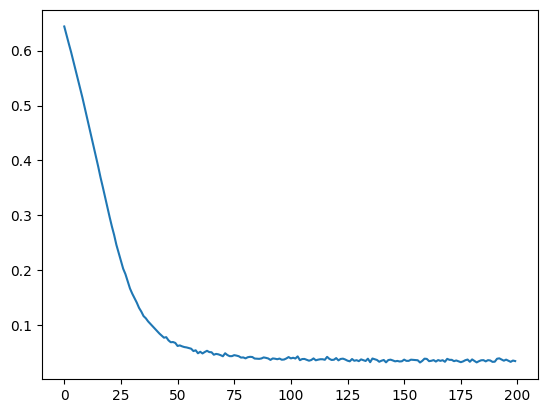

In [42]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [55]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model1.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'j', 'e', 'r', 'e', 't', 'r', 'i', 'y', '<|endoftext|>']


## Weighted Aggregation

First let's just use the mean/average of the first `t` tokens to predict the `t+1` token. What is important is that the `t+1` token only uses the previous tokens to take an average. It should not use any future tokens since we are proceeding strictly left to right in the time dimension. 

In [309]:
batch_size = 4
block_size = max_len-2
print(vocab_size)

29


In [310]:
x = torch.randn(batch_size, block_size, vocab_size)
x.shape

torch.Size([4, 16, 29])

In [311]:
x[1]

tensor([[ 1.6834e+00,  8.5071e-01, -1.1918e+00,  1.0946e+00, -9.6713e-02,
         -7.2817e-01,  7.9290e-01, -2.0925e+00, -5.0025e-01, -4.6411e-01,
         -5.8405e-01,  1.2963e+00, -9.6361e-01, -9.6736e-01, -2.9595e+00,
         -1.2865e+00,  1.7550e+00,  7.1575e-01, -1.4752e+00, -9.3188e-01,
          1.0002e+00, -1.2041e+00, -3.9269e-01, -2.6548e+00,  1.4893e-01,
          8.1709e-01, -1.7680e+00, -1.1756e+00,  1.2117e+00],
        [ 3.8636e-01, -1.7870e-01,  2.1813e+00,  1.4835e+00,  1.7576e-01,
          3.7141e-01, -4.0449e-01, -1.3866e+00, -2.3826e+00,  8.1952e-01,
          1.4596e-01,  2.1205e-01,  1.0887e+00, -8.2900e-02, -7.1157e-01,
          4.8497e-01, -3.8312e-01,  5.1782e-01, -1.0427e-01,  2.1325e-02,
         -1.8728e-01,  1.7348e-01, -2.4391e-01, -1.0773e+00,  7.8323e-01,
         -7.1903e-01,  5.7350e-01,  9.3169e-01,  3.6310e-01],
        [-1.8688e-01, -4.7640e-01,  3.1058e-01, -8.9087e-01, -5.2205e-01,
          1.3370e+00, -2.0267e-01,  3.7638e-01, -6.7568e-01, -

### Weighted Average: Approach 1

In [312]:
x_mean = torch.zeros((batch_size, block_size, vocab_size))
for b in range(batch_size):
    for t in range(block_size):
        x_mean[b, t] = torch.mean(x[b,:t+1], 0)

In [313]:
x_mean[0]

tensor([[-9.4132e-01, -1.1091e+00, -3.3398e-01, -1.0040e+00,  6.6294e-02,
          4.0803e-01,  9.7160e-01,  3.4739e-01, -4.9187e-01, -5.1858e-01,
         -8.4280e-01,  6.7168e-01, -1.2877e+00,  9.3693e-01, -2.1872e-01,
         -2.3756e+00, -9.2784e-01, -6.8388e-01,  2.7231e-01,  6.9204e-01,
          1.2918e+00, -1.0190e+00, -9.9727e-01, -5.1457e-01, -6.0122e-01,
          1.4521e-01,  1.3804e+00,  2.8369e-01, -6.2297e-02],
        [-3.9890e-01, -4.9361e-01, -6.5304e-01, -1.8409e+00,  3.4994e-01,
          1.1646e+00,  3.7222e-01,  1.5721e-01, -1.1974e-01,  1.9240e-01,
         -1.9415e-01, -6.6520e-01, -9.0832e-01,  2.7922e-01, -6.0988e-01,
         -1.1078e+00, -7.8337e-01, -6.9634e-01,  8.8863e-02,  4.7959e-01,
          1.4292e+00, -2.3608e-01, -6.4211e-01, -4.0819e-01, -7.6581e-02,
          7.9989e-02,  1.2136e+00, -6.7002e-01,  4.2918e-01],
        [-5.2758e-02, -1.0183e+00, -1.7154e-01, -6.7730e-01,  3.0393e-01,
          4.7886e-01,  3.1937e-01,  5.4520e-01,  1.9639e-01,  

Now we can see how to compute `x_mean` using more efficient means, namely using a lower triangular matrix which can be created using the `tril` method from PyTorch. The trick is to use matrix multiplication instead of `for` loops to replace `x[b,:t+1]` with a zero mask for the time steps in the future which we do not want to use in our `mean` calculation.

### Weighted Average: Approach 2

In [314]:
a = torch.ones(3,3)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print(f'{a=}')
print(f'{b=}')
print(f'{c=}')

a=tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
b=tensor([[2., 1.],
        [9., 1.],
        [1., 8.]])
c=tensor([[12., 10.],
        [12., 10.],
        [12., 10.]])


To iterate through the time index `t` masking everything in the future from `t+1` onwards we can use a [lower triangular matrix](https://en.wikipedia.org/wiki/Triangular_matrix) using the `torch.tril` function. `tril` is short for lower triangular.

In [315]:
torch.tril(a)

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [316]:
a = torch.tril(torch.ones(3,3))
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print(f'{a=}')
print(f'{b=}')
print(f'{c=}')

a=tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
b=tensor([[3., 1.],
        [5., 2.],
        [7., 9.]])
c=tensor([[ 3.,  1.],
        [ 8.,  3.],
        [15., 12.]])


We can take the mean over each previous time step by taking an (equally) weighted average using the lower triangular matrix as the weights instead of using $1.0$.

In [317]:
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print(f'{a=}')
print(f'{b=}')
print(f'{c=}')

a=tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b=tensor([[3., 0.],
        [2., 0.],
        [3., 4.]])
c=tensor([[3.0000, 0.0000],
        [2.5000, 0.0000],
        [2.6667, 1.3333]])


In [318]:
wavg = torch.tril(torch.ones(block_size, block_size))
wavg = wavg / wavg.sum(1, keepdim=True)
print(wavg, wavg.shape)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

In [319]:
print(x, x.shape)

tensor([[[-0.9413, -1.1091, -0.3340,  ...,  1.3804,  0.2837, -0.0623],
         [ 0.1435,  0.1219, -0.9721,  ...,  1.0467, -1.6237,  0.9207],
         [ 0.6395, -2.0676,  0.7915,  ...,  0.0443,  2.2066, -0.8772],
         ...,
         [-1.4518, -1.0079, -0.4014,  ...,  0.9743, -1.4800, -0.8017],
         [ 0.4199, -0.7237,  0.1456,  ..., -0.2550, -0.7625, -1.6207],
         [ 0.4781, -0.4552,  1.3613,  ..., -0.9300,  0.0151,  0.2607]],

        [[ 1.6834,  0.8507, -1.1918,  ..., -1.7680, -1.1756,  1.2117],
         [ 0.3864, -0.1787,  2.1813,  ...,  0.5735,  0.9317,  0.3631],
         [-0.1869, -0.4764,  0.3106,  ..., -0.4918, -0.6413, -0.8319],
         ...,
         [ 1.6178,  0.8509, -0.2857,  ..., -1.6211, -0.0807,  1.1747],
         [-0.1415, -0.1784, -0.2899,  ...,  2.6533, -0.0902,  1.6141],
         [ 0.7731, -0.3166, -0.9337,  ...,  0.1325,  1.0421,  2.3761]],

        [[-1.2399,  0.3417,  0.8661,  ...,  0.2320,  0.2173, -0.6327],
         [ 1.0235, -0.9156,  0.5308,  ..., -0

Take advantage of Pytorch broadcasting to create a batch dimension implicitly for `wavg` so that it can be multiplied with `x`.

`wavg` of shape (T, T) becomes (B, T, T) which is multiplied by `x` of shape (B, T, C) to produce a (B, T, C) tensor.

In [320]:
x_mean2 = wavg @ x
x_mean2.shape

torch.Size([4, 16, 29])

In [321]:
x_mean[0], x_mean2[0]

(tensor([[-9.4132e-01, -1.1091e+00, -3.3398e-01, -1.0040e+00,  6.6294e-02,
           4.0803e-01,  9.7160e-01,  3.4739e-01, -4.9187e-01, -5.1858e-01,
          -8.4280e-01,  6.7168e-01, -1.2877e+00,  9.3693e-01, -2.1872e-01,
          -2.3756e+00, -9.2784e-01, -6.8388e-01,  2.7231e-01,  6.9204e-01,
           1.2918e+00, -1.0190e+00, -9.9727e-01, -5.1457e-01, -6.0122e-01,
           1.4521e-01,  1.3804e+00,  2.8369e-01, -6.2297e-02],
         [-3.9890e-01, -4.9361e-01, -6.5304e-01, -1.8409e+00,  3.4994e-01,
           1.1646e+00,  3.7222e-01,  1.5721e-01, -1.1974e-01,  1.9240e-01,
          -1.9415e-01, -6.6520e-01, -9.0832e-01,  2.7922e-01, -6.0988e-01,
          -1.1078e+00, -7.8337e-01, -6.9634e-01,  8.8863e-02,  4.7959e-01,
           1.4292e+00, -2.3608e-01, -6.4211e-01, -4.0819e-01, -7.6581e-02,
           7.9989e-02,  1.2136e+00, -6.7002e-01,  4.2918e-01],
         [-5.2758e-02, -1.0183e+00, -1.7154e-01, -6.7730e-01,  3.0393e-01,
           4.7886e-01,  3.1937e-01,  5.4520e-01, 

In [322]:
print(x_mean.shape, x_mean2.shape)

torch.Size([4, 16, 29]) torch.Size([4, 16, 29])


Check if the compute efficient `x_mean2` is the same as the `for` loop based `x_mean` (from above)

In [323]:
torch.allclose(x_mean, x_mean2, rtol=1e-02)

True

### Weighted Average: Approach 3

In [324]:
tril = torch.tril(torch.ones(block_size, block_size))
wavg = torch.zeros((block_size, block_size))
wavg = wavg.masked_fill(tril == 0, float('-inf'))
wavg

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [325]:
wavg = F.softmax(wavg, dim=-1)
wavg

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

In [326]:
x_mean3 = wavg @ x
x_mean3[0]

tensor([[-9.4132e-01, -1.1091e+00, -3.3398e-01, -1.0040e+00,  6.6294e-02,
          4.0803e-01,  9.7160e-01,  3.4739e-01, -4.9187e-01, -5.1858e-01,
         -8.4280e-01,  6.7168e-01, -1.2877e+00,  9.3693e-01, -2.1872e-01,
         -2.3756e+00, -9.2784e-01, -6.8388e-01,  2.7231e-01,  6.9204e-01,
          1.2918e+00, -1.0190e+00, -9.9727e-01, -5.1457e-01, -6.0122e-01,
          1.4521e-01,  1.3804e+00,  2.8369e-01, -6.2297e-02],
        [-3.9890e-01, -4.9361e-01, -6.5304e-01, -1.8409e+00,  3.4994e-01,
          1.1646e+00,  3.7222e-01,  1.5721e-01, -1.1974e-01,  1.9240e-01,
         -1.9415e-01, -6.6520e-01, -9.0832e-01,  2.7922e-01, -6.0988e-01,
         -1.1078e+00, -7.8337e-01, -6.9634e-01,  8.8863e-02,  4.7959e-01,
          1.4292e+00, -2.3608e-01, -6.4211e-01, -4.0819e-01, -7.6581e-02,
          7.9989e-02,  1.2136e+00, -6.7002e-01,  4.2918e-01],
        [-5.2758e-02, -1.0183e+00, -1.7154e-01, -6.7730e-01,  3.0393e-01,
          4.7886e-01,  3.1937e-01,  5.4520e-01,  1.9639e-01,  

In [327]:
torch.allclose(x_mean, x_mean3, rtol=1e-02)

True

## Layer Normalization

In [54]:
embedding = torch.randn(5)
print(embedding)
print(embedding.mean())
print(embedding.std())
t = (embedding - embedding.mean()) / (embedding.std() + 0.00001)
print(t)
#embedding = torch.randn(batch, sentence_length, embedding_dim)
layer_norm = nn.LayerNorm(5)
embedding = layer_norm(embedding)
print(embedding)

tensor([ 0.2951,  1.0258,  0.2767, -0.6840, -0.0438])
tensor(0.1740)
tensor(0.6193)
tensor([ 0.1956,  1.3754,  0.1658, -1.3852, -0.3516])
tensor([ 0.2187,  1.5377,  0.1854, -1.5487, -0.3931],
       grad_fn=<NativeLayerNormBackward0>)


## Self-Attention

In [63]:
batch_size = 4 # the batch size, B
block_size = 8 # the time dimension, T
vocab_size = 29 # also called the channel size, C

x = torch.randn(batch_size, block_size, vocab_size)
x.shape

torch.Size([4, 8, 29])

In [57]:
tril = torch.tril(torch.ones(block_size, block_size))
wavg = torch.zeros((block_size, block_size))
wavg = wavg.masked_fill(tril == 0, float('-inf'))
wavg = F.softmax(wavg, dim=-1)
x_mean3 = wavg @ x
x_mean3.shape

torch.Size([4, 8, 32])

In [330]:
tril

tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])

In [331]:
wavg # weighted average over the input

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])

### Single head self-attention

We define a representation over the input `x` in terms of keys $K$, queries $Q$ and values $V$

$$
  \text{Attention}(Q, K, V) = \text{softmax}(\frac{Q K^T}{\sqrt{d_k}}) V
$$

$\sqrt{d_k}$ is a scaling factor which uses the dimensionality $d_k$ of the queries and keys.

In [64]:
head_size = 16
key = nn.Linear(vocab_size, head_size, bias=False)
query = nn.Linear(vocab_size, head_size, bias=False)

In [65]:
k = key(x) # (vocab_size, head_size, 16)
k.shape

torch.Size([4, 8, 16])

In [66]:
tmp = k.transpose(-2, -1)
tmp.shape

torch.Size([4, 16, 8])

In [67]:
q = query(x) # (vocab_size, head_size, 16)
q.shape

torch.Size([4, 8, 16])

In [68]:
wavg = q @ k.transpose(-2, -1)
# [4,8,16] @ [4,16,8] = [4,8,8]
wavg.shape

torch.Size([4, 8, 8])

In [69]:
# ignore the future tokens for each token (as before)
tril = torch.tril(torch.ones(block_size, block_size))
wavg = wavg.masked_fill(tril == 0, float('-inf'))
# renormalize and produce a probability
wavg = F.softmax(wavg, dim=-1)
x_mean4 = wavg @ x
x_mean4.shape

torch.Size([4, 8, 29])

In [70]:
wavg[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9442, 0.0558, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2920, 0.3707, 0.3373, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3052, 0.1587, 0.2039, 0.3322, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3856, 0.2707, 0.2289, 0.0036, 0.1112, 0.0000, 0.0000, 0.0000],
        [0.0842, 0.6779, 0.1842, 0.0263, 0.0046, 0.0227, 0.0000, 0.0000],
        [0.1594, 0.0759, 0.4602, 0.0311, 0.0247, 0.2068, 0.0418, 0.0000],
        [0.0552, 0.0685, 0.1234, 0.5404, 0.1132, 0.0411, 0.0246, 0.0336]],
       grad_fn=<SelectBackward0>)

In [71]:
print(x_mean4[0].shape)
x_mean4[0]

torch.Size([8, 29])


tensor([[ 0.1947, -0.8614, -0.5083, -0.3529, -0.1358,  1.4820,  1.4886, -0.9384,
          0.2623, -1.8658,  0.8768,  1.1395, -1.5229, -1.5768, -0.8369, -1.9511,
         -1.1709, -1.7596, -0.3987, -0.4140, -0.6491,  0.2528,  0.3411,  1.1293,
          0.0955,  0.2029, -0.2139,  0.8559,  0.2341],
        [ 0.3115, -0.8429, -0.4778, -0.3691, -0.2109,  1.4309,  1.3881, -0.8339,
          0.3616, -1.6375,  0.8834,  1.1080, -1.5249, -1.3309, -0.7426, -1.8417,
         -1.0912, -1.6782, -0.3746, -0.3254, -0.6856,  0.2420,  0.3640,  0.9865,
          0.0092,  0.2056, -0.2130,  0.8507,  0.2016],
        [ 1.3948, -0.0580, -0.5200, -0.0653, -0.2932,  0.6771,  0.1597, -0.2073,
          1.1430,  0.0142,  0.5587,  0.7401, -1.1059,  0.6709,  0.0657, -0.4953,
         -0.4802, -0.8185, -0.3558,  0.0377, -0.5771,  0.1932,  0.5633, -0.1606,
         -0.8496,  0.3977, -0.2126,  0.9004, -0.4243],
        [ 0.1938,  0.0472, -0.7243,  0.6680, -0.3437,  0.4680,  0.5583,  0.1517,
          0.2904,  0.0268

In [72]:
value = nn.Linear(vocab_size, head_size, bias=False)

In [73]:
v = value(x)
v.shape

torch.Size([4, 8, 16])

In [74]:
x_mean5 = wavg @ v
x_mean5.shape

torch.Size([4, 8, 16])

In the above, the attention mechanism is similar to a weighted average over a bag of words. To know about the structure of language, we have to add positional information to each token so that the representation of `it` in position 2 will be different from the representation of `it` in postion 24.

The keys, queries and values all come from input `x`. If we have queries coming from `x` but the keys and values come from a different sequence then the attention is called **cross-attention**.

### Scaled attention

A naive dot product of keys and queries will lead to a variance that is proportional to the value of `head_size`.

In [89]:
k = torch.randn(batch_size, block_size, head_size)
q = torch.randn(batch_size, block_size, head_size)
wavg_noscale = q @ k.transpose(-2, -1)
print(f'key variance={k.var()}')
print(f'query variance={q.var()}')
print(f'wavg variance={wavg_noscale.var()}')
print(f'{head_size=}')

key variance=1.0184979438781738
query variance=0.9985140562057495
wavg variance=18.387861251831055
head_size=16


Scaling down the dot product by the square root of the head size gives us a variance that is similar to the key and query variance. This means that when we take the softmax over the dot product we don't get highly scaled values that can lead to very confident probability distributions soon after initialization. To make the parameter updates more conservative especially in the early stages of training, scaled dot-products perform much better by reducing the variance of the weighted average.

In [100]:
k = torch.randn(batch_size, block_size, head_size)
q = torch.randn(batch_size, block_size, head_size)
wavg = q @ k.transpose(-2, -1) * head_size**(-0.5)
print(f'key variance={k.var()}')
print(f'query variance={q.var()}')
print(f'wavg variance={wavg.var()}')

key variance=0.9879302382469177
query variance=1.152884602546692
wavg variance=0.991986095905304


In [101]:
k = key(x) # (vocab_size, head_size, 16)
q = query(x) # (vocab_size, head_size, 16)
wavg = q @ k.transpose(-2, -1) * head_size**(-0.5)
wavg.var()

tensor(0.1148, grad_fn=<VarBackward0>)

In [102]:
# ignore the future tokens for each token (as before)
tril = torch.tril(torch.ones(block_size, block_size))
wavg = wavg.masked_fill(tril == 0, float('-inf'))
# renormalize and produce a probability
wavg = F.softmax(wavg, dim=-1)
v = value(x)
x_mean6 = wavg @ x
x_mean6.shape

torch.Size([4, 8, 29])

## Transformer language model

In [105]:
class Head(nn.Module):
    """ single head of self attention """

    def __init__(self, n_embed, block_size, head_size):
        super().__init__()
        self.n_embed = n_embed
        self.block_size = block_size
        self.head_size = head_size
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        batch_size, block_size, head_size = x.shape
        k = self.key(x)   # (batch_size, block_size, head_size)
        q = self.query(x) # (batch_size, block_size, head_size)
        # compute weighted average using scaled attention
        wavg = q @ k.transpose(-2, -1) * head_size**(-0.5)
        # wavg.shape = (batch_size, block_size, head_size) @ (batch_size, head_size, block_size)
        # wavg.shape = (batch_size, block_size, block_size)
        wavg = wavg.masked_fill(self.tril[:block_size, :block_size] == 0, float('-inf'))
        # wavg.shape = (batch_size, block_size, block_size)
        wavg = F.softmax(wavg, dim=-1)
        # wavg.shape = (batch_size, block_size, block_size)
        v = self.value(x) # (batch_size, block_size, head_size)
        # wavg @ v : (batch_size, block_size, block_size) @ (batch_size, block_size, head_size)
        # wavg @ v : (batch_size, block_size, head_size)
        return wavg @ v

In [106]:
class SimpleTransformerLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size, head_size):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.self_attn_head = Head(n_embed, block_size, head_size) # (D, T, D)
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # D: size of embedding
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, D)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, D)
        x = token_embed + position_embed # (B, T, D)
        x = self.self_attn_head(x) # apply one head of self attention: (B, T, D)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

## Training the Transformer LM

In [107]:
vocab = sorted(list({ c for ex in dataset for c in ex }))
vocab_size = len(vocab)
print(''.join(vocab))
print(f'{vocab_size=}')

batch_size = 4
n_embed = 32
n_heads = 1
block_size = max_len-2
head_size = n_embed // n_heads
print(f'{head_size=}')

<|endoftext|><|padtoken|><|starttext|>abcdefghijklmnopqrstuvwxyz
vocab_size=29
head_size=32


In [108]:
embed = nn.Embedding(vocab_size, n_embed)
xb, yb = get_batch('train', block_size, batch_size)
print(xb)
embed(xb)

tensor([[ 0, 17, 14,  7,  9,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 11, 20,  3, 16,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0,  4,  7, 14, 13, 27,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 16,  3, 28,  3, 16, 11, 16,  1,  2,  2,  2,  2,  2,  2,  2]])


tensor([[[-1.2006, -0.5894, -0.7068,  ..., -0.2857,  0.9019, -0.0317],
         [ 0.6098,  0.5099, -0.3944,  ..., -1.5293, -1.7875,  1.1484],
         [-0.1351,  0.7877,  0.5673,  ..., -1.3588,  1.2834,  1.4518],
         ...,
         [-2.3244,  1.3288,  0.5057,  ..., -2.1503,  0.1276, -0.0079],
         [-2.3244,  1.3288,  0.5057,  ..., -2.1503,  0.1276, -0.0079],
         [-2.3244,  1.3288,  0.5057,  ..., -2.1503,  0.1276, -0.0079]],

        [[-1.2006, -0.5894, -0.7068,  ..., -0.2857,  0.9019, -0.0317],
         [-0.3178,  1.2092, -1.4880,  ..., -0.7475,  1.8186, -0.4076],
         [-0.4106, -0.3308, -0.2295,  ..., -0.2547,  0.8725, -0.1601],
         ...,
         [-2.3244,  1.3288,  0.5057,  ..., -2.1503,  0.1276, -0.0079],
         [-2.3244,  1.3288,  0.5057,  ..., -2.1503,  0.1276, -0.0079],
         [-2.3244,  1.3288,  0.5057,  ..., -2.1503,  0.1276, -0.0079]],

        [[-1.2006, -0.5894, -0.7068,  ..., -0.2857,  0.9019, -0.0317],
         [ 1.0456,  0.6095, -0.2372,  ..., -0

In [109]:
model2 = SimpleTransformerLM(n_embed, vocab_size, block_size, head_size)
optimizer2 = optim.Adam(model2.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model2)

SimpleTransformerLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (self_attn_head): Head(
    (key): Linear(in_features=32, out_features=32, bias=False)
    (query): Linear(in_features=32, out_features=32, bias=False)
    (value): Linear(in_features=32, out_features=32, bias=False)
  )
  (predict): Linear(in_features=32, out_features=29, bias=True)
)


### Training Loop

In [110]:
n_updates = 10000

Sample a batch of training data and send it through the forward pass of the network to obtain the logits 

In [111]:
xb, _ = get_batch('train', block_size, batch_size)
print(xb)
model2(xb)

tensor([[ 0, 13,  3, 22, 11,  7, 15,  3,  7,  1,  2,  2,  2,  2,  2,  2],
        [ 0, 13, 11, 27,  3, 16, 16,  3,  1,  2,  2,  2,  2,  2,  2,  2],
        [ 0, 14,  7, 27, 22, 17, 16,  1,  2,  2,  2,  2,  2,  2,  2,  2],
        [ 0,  3, 11, 16, 17,  3,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2]])


tensor([[[ 0.0928,  0.1426, -0.6582,  ...,  0.2871, -0.6518,  0.5082],
         [ 0.0067,  0.3414, -0.2680,  ..., -0.4421, -0.4206,  0.1865],
         [-0.0269,  0.2264, -0.2679,  ..., -0.1071, -0.3484,  0.2379],
         ...,
         [ 0.0641, -0.1578, -0.2706,  ..., -0.2137, -0.0472, -0.2120],
         [ 0.0033, -0.1315, -0.1736,  ..., -0.2772, -0.0461, -0.1137],
         [ 0.0491, -0.1434, -0.2453,  ..., -0.2620, -0.0384, -0.1486]],

        [[ 0.0928,  0.1426, -0.6582,  ...,  0.2871, -0.6518,  0.5082],
         [ 0.0067,  0.3414, -0.2680,  ..., -0.4421, -0.4206,  0.1865],
         [-0.3650, -0.0161, -0.1246,  ..., -0.1621, -0.2025, -0.0149],
         ...,
         [-0.0450, -0.1604, -0.2226,  ..., -0.3642, -0.0492, -0.2542],
         [-0.0363, -0.1427, -0.1224,  ..., -0.3709, -0.0930, -0.2161],
         [ 0.0123, -0.1205, -0.1649,  ..., -0.3818, -0.0735, -0.2075]],

        [[ 0.0928,  0.1426, -0.6582,  ...,  0.2871, -0.6518,  0.5082],
         [-0.2197, -0.0025, -0.5031,  ...,  0

Compare the logits with the ground truth labels and compute the loss

In [112]:
xb, yb = get_batch('train', block_size, batch_size)
model2.loss(model2(xb), yb)

tensor(3.5428, grad_fn=<NllLossBackward0>)

In [114]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model2(xb)
    loss = model2.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer2.zero_grad()
    loss.backward()
    optimizer2.step()

print(f'loss={loss.item()}')

loss=1.0514332056045532


### Calculate validation loss

In [115]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model2(xb)
val_loss = model2.loss(logits, yb)
print(val_loss)

tensor(1.2690, grad_fn=<NllLossBackward0>)


### Plot the average loss

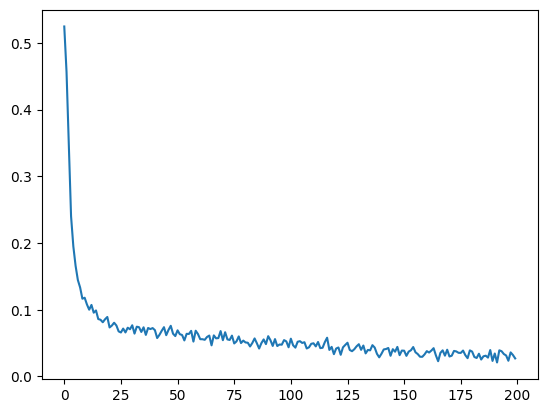

In [116]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

Start with `<|starttext|>` as the "prompt".

In [117]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)

In [128]:
print(decode(model2.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'f', 'y', 'a', 'l', 'a', 'a', 'i', '<|endoftext|>']


### Multihead Attention

In [130]:
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_embed, block_size, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed, block_size, head_size) for _ in range(n_heads)])

    def forward(self, x):
        return torch.cat([h(x) for h in self.heads], dim=-1)

In [131]:
class MultiHeadTransformerLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size, n_heads):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.self_attn_head = MultiHeadAttention(n_embed, block_size, n_heads, n_embed//n_heads) # (D, T, C)
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, C)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, C)
        x = token_embed + position_embed # (B, T, C)
        x = self.self_attn_head(x) # apply one head of self attention: (B, T, C)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [133]:
n_heads = 4
model3 = MultiHeadTransformerLM(n_embed, vocab_size, block_size, n_heads)
optimizer3 = optim.Adam(model3.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model3)

MultiHeadTransformerLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (self_attn_head): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (key): Linear(in_features=32, out_features=8, bias=False)
        (query): Linear(in_features=32, out_features=8, bias=False)
        (value): Linear(in_features=32, out_features=8, bias=False)
      )
    )
  )
  (predict): Linear(in_features=32, out_features=29, bias=True)
)


### Training Loop

In [135]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model3(xb)
    loss = model3.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer3.zero_grad()
    loss.backward()
    optimizer3.step()

print(f'loss={loss.item()}')

loss=1.296251654624939


### Calculate validation loss

In [136]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model3(xb)
val_loss = model3.loss(logits, yb)
print(val_loss)

tensor(1.3426, grad_fn=<NllLossBackward0>)


### Plot the average loss

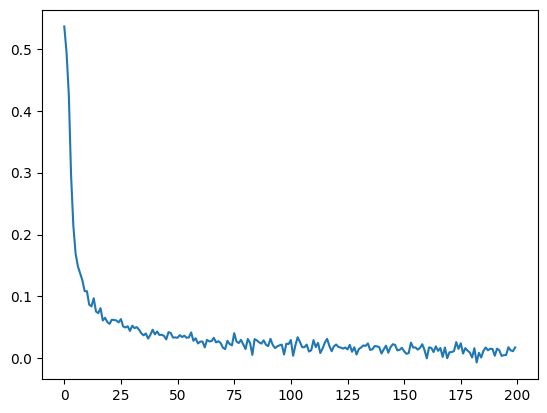

In [137]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [154]:
print(decode(model3.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'j', 'e', 'n', 'v', 'i', 'n', '<|endoftext|>']


## Adding Feedforward Layer to the Transformer

In [155]:
class FeedForward(nn.Module):
    """ simple linear layer followed by non-linear transfer function """

    def __init__(self, n_embed):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embed, n_embed),
            nn.GELU(),
        )

    def forward(self, x):
        return self.ff(x)

In [156]:
class MultiHeadTransformerFFLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size, n_heads):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.self_attn_head = MultiHeadAttention(n_embed, block_size, n_heads, n_embed//n_heads) # (D, T, C)
        self.ffwd = FeedForward(n_embed)
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, C)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, C)
        x = token_embed + position_embed # (B, T, C)
        x = self.self_attn_head(x) # apply one head of self attention: (B, T, C)
        x = self.ffwd(x) # (B, T, C)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [157]:
n_heads = 4
model4 = MultiHeadTransformerFFLM(n_embed, vocab_size, block_size, n_heads)
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model4)

MultiHeadTransformerFFLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (self_attn_head): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (key): Linear(in_features=32, out_features=8, bias=False)
        (query): Linear(in_features=32, out_features=8, bias=False)
        (value): Linear(in_features=32, out_features=8, bias=False)
      )
    )
  )
  (ffwd): FeedForward(
    (ff): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (predict): Linear(in_features=32, out_features=29, bias=True)
)


### Training Loop

In [158]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model4(xb)
    loss = model4.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer4.zero_grad()
    loss.backward()
    optimizer4.step()

print(f'loss={loss.item()}')

loss=0.9720293879508972


### Calculate validation loss

In [159]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model3(xb)
val_loss = model3.loss(logits, yb)
print(val_loss)

tensor(0.9665, grad_fn=<NllLossBackward0>)


### Plot the average loss

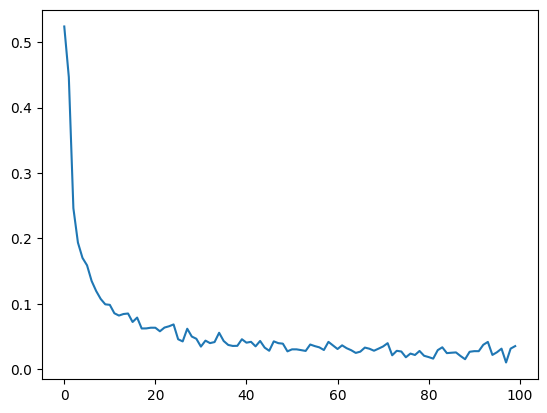

In [160]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [170]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model4.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'd', 'i', 'r', 'y', 'i', 's', '<|endoftext|>']


In [171]:
n_heads = 4
model4 = MultiHeadTransformerFFLM(n_embed, vocab_size, block_size, n_heads)
optimizer4 = optim.Adam(model4.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model4)

MultiHeadTransformerFFLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (self_attn_head): MultiHeadAttention(
    (heads): ModuleList(
      (0-3): 4 x Head(
        (key): Linear(in_features=32, out_features=8, bias=False)
        (query): Linear(in_features=32, out_features=8, bias=False)
        (value): Linear(in_features=32, out_features=8, bias=False)
      )
    )
  )
  (ffwd): FeedForward(
    (ff): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (predict): Linear(in_features=32, out_features=29, bias=True)
)


### Training Loop

In [172]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model4(xb)
    loss = model4.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer4.zero_grad()
    loss.backward()
    optimizer4.step()

print(f'loss={loss.item()}')

loss=1.1932103633880615


### Calculate validation loss

In [173]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model4(xb)
val_loss = model4.loss(logits, yb)
print(val_loss)

tensor(1.0247, grad_fn=<NllLossBackward0>)


### Plot the average loss

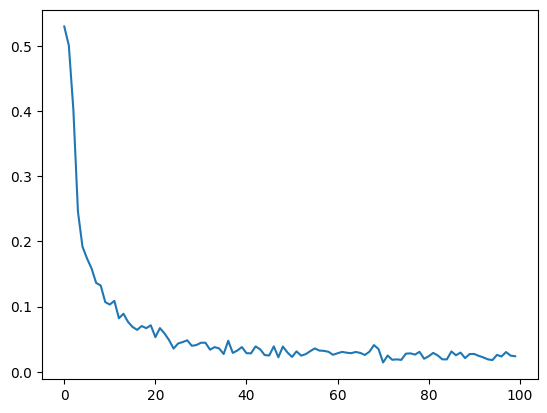

In [174]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [180]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model4.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'a', 'i', 'm', 's', 'e', 'e', '<|endoftext|>']


## Adding a Transformer Block for Multiple Layers

In [181]:
class TransformerBlock(nn.Module):

    def __init__(self, n_embed, block_size, n_heads):
        super().__init__()
        self.head_size = n_embed // n_heads
        self.self_attn_head = MultiHeadAttention(n_embed, block_size, n_heads, self.head_size) # (D, T, C)
        self.ffwd = FeedForward(n_embed)

    def forward(self, x):
        x = self.self_attn_head(x)
        x = self.ffwd(x)
        return x

In [183]:
class MultiHeadTransformerBlockLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size, n_heads):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.blocks = nn.Sequential(
            TransformerBlock(n_embed, block_size, n_heads),
            TransformerBlock(n_embed, block_size, n_heads),
        )            
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, C)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, C)
        x = token_embed + position_embed # (B, T, C)
        x = self.blocks(x)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [184]:
n_heads = 4
model5 = MultiHeadTransformerBlockLM(n_embed, vocab_size, block_size, n_heads)
optimizer5 = optim.Adam(model5.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model5)

MultiHeadTransformerBlockLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (blocks): Sequential(
    (0): TransformerBlock(
      (self_attn_head): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
          )
        )
      )
      (ffwd): FeedForward(
        (ff): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): GELU(approximate='none')
        )
      )
    )
    (1): TransformerBlock(
      (self_attn_head): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_fea

### Training Loop

In [185]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model5(xb)
    loss = model5.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer5.zero_grad()
    loss.backward()
    optimizer5.step()

print(f'loss={loss.item()}')

loss=0.8917997479438782


### Calculate validation loss

In [186]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model5(xb)
val_loss = model5.loss(logits, yb)
print(val_loss)

tensor(1.1112, grad_fn=<NllLossBackward0>)


### Plot the average loss

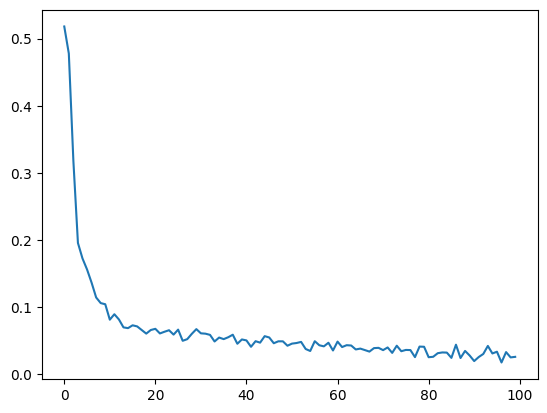

In [187]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [198]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model5.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'a', 'n', 'r', 'y', 'n', 'a', 'a', 'l', 'o', 'e', 'e', '<|endoftext|>']


## Adding Residual Connections

In [205]:
class MultiHeadAttentionResiduals(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_embed, block_size, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(n_embed, block_size, head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embed, n_embed)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.proj(out)

In [206]:
class FeedForwardResiduals(nn.Module):
    """ simple linear layer followed by non-linear transfer function """

    def __init__(self, n_embed):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed), # grow the feedforward layer internally
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed),
        )

    def forward(self, x):
        return self.ff(x)

In [207]:
class TransformerBlockResiduals(nn.Module):

    def __init__(self, n_embed, block_size, n_heads):
        super().__init__()
        self.head_size = n_embed // n_heads
        self.self_attn_head = MultiHeadAttentionResiduals(n_embed, block_size, n_heads, self.head_size) # (D, T, C)
        self.ffwd = FeedForwardResiduals(n_embed)

    def forward(self, x):
        x = x + self.self_attn_head(x) # add residual connections
        x = x + self.ffwd(x)           # add residual connections
        return x

In [208]:
class MultiHeadTransformerBlockResidualsLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size, n_heads):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.blocks = nn.Sequential(
            TransformerBlockResiduals(n_embed, block_size, n_heads),
            TransformerBlockResiduals(n_embed, block_size, n_heads),
        )            
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, C)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, C)
        x = token_embed + position_embed # (B, T, C)
        x = self.blocks(x)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [209]:
n_heads = 4
model6 = MultiHeadTransformerBlockResidualsLM(n_embed, vocab_size, block_size, n_heads)
optimizer6 = optim.Adam(model6.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model6)

MultiHeadTransformerBlockResidualsLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (blocks): Sequential(
    (0): TransformerBlockResiduals(
      (self_attn_head): MultiHeadAttentionResiduals(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (ffwd): FeedForwardResiduals(
        (ff): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
    )
    (1): TransformerBlockResiduals(
      (self_attn_head): MultiHeadAttentionResiduals(
        (heads): ModuleList(
          (0-3): 4 x Head(
    

### Training Loop

In [210]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model6(xb)
    loss = model6.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer6.zero_grad()
    loss.backward()
    optimizer6.step()

print(f'loss={loss.item()}')

loss=0.9630934596061707


### Calculate validation loss

In [211]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model6(xb)
val_loss = model6.loss(logits, yb)
print(val_loss)

tensor(0.9377, grad_fn=<NllLossBackward0>)


### Plot the average loss

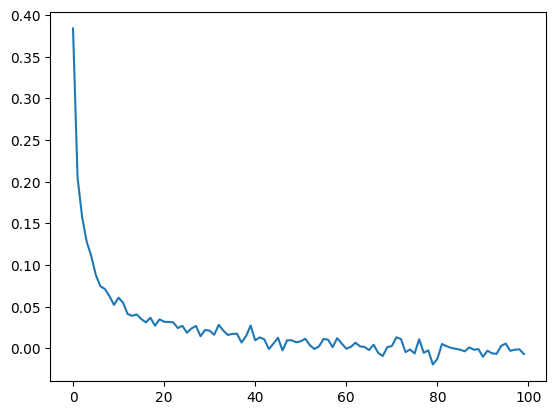

In [212]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [222]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model6.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'j', 'i', 'l', 'a', '<|endoftext|>']


## Add LayerNorm

In [223]:
class TransformerBlockResidualsLayerNorm(nn.Module):

    def __init__(self, n_embed, block_size, n_heads):
        super().__init__()
        self.head_size = n_embed // n_heads
        self.self_attn_head = MultiHeadAttentionResiduals(n_embed, block_size, n_heads, self.head_size) # (D, T, C)
        self.ffwd = FeedForwardResiduals(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.self_attn_head(self.ln1(x)) # add LayerNorm inside (pre-norm)
        x = x + self.ffwd(self.ln2(x))           # add LayerNorm inside (pre-norm)
        return x

In [224]:
class MultiHeadTransformerBlockResidualsLayerNormLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size, n_heads):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.blocks = nn.Sequential(
            TransformerBlockResidualsLayerNorm(n_embed, block_size, n_heads),
            TransformerBlockResidualsLayerNorm(n_embed, block_size, n_heads),
            nn.LayerNorm(n_embed)
        )            
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, C)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, C)
        x = token_embed + position_embed # (B, T, C)
        x = self.blocks(x)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [225]:
n_heads = 4
model7 = MultiHeadTransformerBlockResidualsLM(n_embed, vocab_size, block_size, n_heads)
optimizer7 = optim.Adam(model7.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model7)

MultiHeadTransformerBlockResidualsLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (blocks): Sequential(
    (0): TransformerBlockResiduals(
      (self_attn_head): MultiHeadAttentionResiduals(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
      )
      (ffwd): FeedForwardResiduals(
        (ff): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
        )
      )
    )
    (1): TransformerBlockResiduals(
      (self_attn_head): MultiHeadAttentionResiduals(
        (heads): ModuleList(
          (0-3): 4 x Head(
    

### Training Loop

In [226]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model7(xb)
    loss = model7.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer7.zero_grad()
    loss.backward()
    optimizer7.step()

print(f'loss={loss.item()}')

loss=0.8591676950454712


### Calculate validation loss

In [227]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model7(xb)
val_loss = model7.loss(logits, yb)
print(val_loss)

tensor(1.1787, grad_fn=<NllLossBackward0>)


### Plot the average loss

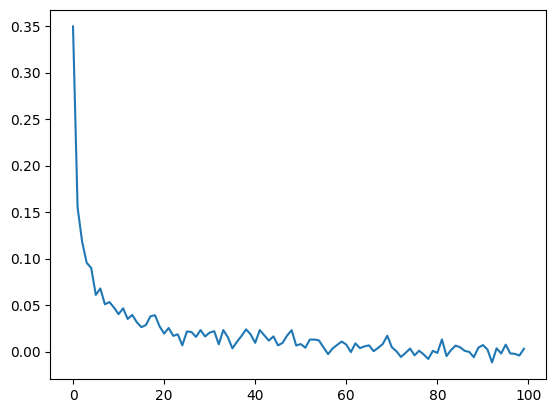

In [228]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [244]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model7.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'm', 'a', 'y', 'l', 'y', 'y', '<|endoftext|>']


## Final Transformer Model

Clean up the code and add a new initialization variable called `n_layers` to control the number of Transformer blocks. Also introduce `dropout` to add some regularization to the learning.

In [245]:
class HeadDropout(nn.Module):
    """ single head of self attention """

    def __init__(self, n_embed, block_size, head_size):
        super().__init__()
        self.n_embed = n_embed
        self.block_size = block_size
        self.head_size = head_size
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        # add dropout after softmax
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, block_size, head_size = x.shape
        k = self.key(x)   # (batch_size, block_size, head_size)
        q = self.query(x) # (batch_size, block_size, head_size)
        # compute weighted average using scaled attention
        wavg = q @ k.transpose(-2, -1) * head_size**(-0.5)
        # wavg.shape = (batch_size, block_size, head_size) @ (batch_size, head_size, block_size)
        # wavg.shape = (batch_size, block_size, block_size)
        wavg = wavg.masked_fill(self.tril[:block_size, :block_size] == 0, float('-inf'))
        # wavg.shape = (batch_size, block_size, block_size)
        wavg = F.softmax(wavg, dim=-1)
        wavg = self.dropout(wavg)
        # wavg.shape = (batch_size, block_size, block_size)
        v = self.value(x) # (batch_size, block_size, head_size)
        # wavg @ v : (batch_size, block_size, block_size) @ (batch_size, block_size, head_size)
        # wavg @ v : (batch_size, block_size, head_size)
        return wavg @ v

In [246]:
class MultiHeadAttentionResidualsDropout(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, n_embed, block_size, n_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([HeadDropout(n_embed, block_size, head_size) for _ in range(n_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.dropout(self.proj(out))

In [247]:
class FeedForwardResidualsDropout(nn.Module):
    """ simple linear layer followed by non-linear transfer function """

    def __init__(self, n_embed):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed), # grow the feedforward layer internally
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.ff(x)

In [248]:
class TransformerBlockResidualsLayerNormDropout(nn.Module):

    def __init__(self, n_embed, block_size, n_heads):
        super().__init__()
        self.head_size = n_embed // n_heads
        self.self_attn_head = MultiHeadAttentionResidualsDropout(n_embed, block_size, n_heads, self.head_size) # (D, T, C)
        self.ffwd = FeedForwardResidualsDropout(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.self_attn_head(self.ln1(x)) # add LayerNorm inside (pre-norm)
        x = x + self.ffwd(self.ln2(x))           # add LayerNorm inside (pre-norm)
        return x

In [249]:
class TransformerLM(nn.Module):

    def __init__(self, n_embed, vocab_size, block_size=8, n_heads=4, n_layers=2):
        super().__init__()
        self.n_embed = n_embed
        self.vocab_size = vocab_size
        self.head_size = head_size
        self.block_size = block_size
        self.token_embed = nn.Embedding(vocab_size, n_embed) # (C, D)
        self.position_embed = nn.Embedding(block_size, n_embed) # (T, D)
        self.blocks = nn.Sequential(
            *[
                TransformerBlockResidualsLayerNormDropout(n_embed, block_size, n_heads) 
                  for _ in range(n_layers)
            ]
        )
        self.ln_final = nn.LayerNorm(n_embed)
        self.predict = nn.Linear(n_embed, vocab_size)

    def forward(self, idx):
        # B: batch_size
        # T: block_size aka time
        # C: channel_size aka vocab_size
        # D: hidden layer dimension
        # idx is a (B,T) size tensor
        batch_size, block_size = idx.shape
        token_embed = self.token_embed(idx) # (B, T, D)
        position_embed = self.position_embed(torch.arange(block_size)) # (T, D)
        x = token_embed + position_embed # (B, T, D)
        x = self.blocks(x)
        x = self.ln_final(x)
        return self.predict(x) # return logits (B, T, vocab_size)

    def loss(self, logits, targets):
        # logits is a (B, T, C) tensor
        # target is a (B, T) size tensor
        return F.cross_entropy(
                logits.view(-1, self.vocab_size), # convert to (B*T, C) tensor
                targets.view(-1) # convert to (B*T) tensor
                )

    def generate(self, idx, max_new_tokens):
        # idx is a (B, T) size tensor of indices
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits = self(idx_cond) # ignore loss
            # use the last time step
            logits = logits[:, -1, :] # which is size (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # size (B, C)
            # sample from this probability distribution
            idx_next = torch.multinomial(probs, num_samples=1) # size (B, 1)
            if itos[idx_next.item()] in ('<|startoftext|>', '<|padtoken|>'):
                continue
            # append sampled token to sequence
            idx = torch.cat((idx, idx_next), dim=1) # size (B, T+1)
            decoded = decode(idx[-1].tolist())
            if decoded[-1] == '<|endoftext|>':
                break
        return idx

In [251]:
n_heads = 4
n_layers = 4
dropout = 0.2
batch_size = 4
block_size = max_len-2
model8 = TransformerLM(n_embed, vocab_size, block_size=block_size, n_heads=n_heads, n_layers=n_layers)
optimizer8 = optim.Adam(model8.parameters(), lr=1e-4)
losses = []
validation_losses = []
print(model8)

TransformerLM(
  (token_embed): Embedding(29, 32)
  (position_embed): Embedding(16, 32)
  (blocks): Sequential(
    (0): TransformerBlockResidualsLayerNormDropout(
      (self_attn_head): MultiHeadAttentionResidualsDropout(
        (heads): ModuleList(
          (0-3): 4 x HeadDropout(
            (key): Linear(in_features=32, out_features=8, bias=False)
            (query): Linear(in_features=32, out_features=8, bias=False)
            (value): Linear(in_features=32, out_features=8, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForwardResidualsDropout(
        (ff): Sequential(
          (0): Linear(in_features=32, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Linear(in_features=128, out_features=32, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
  

### Training Loop

In [252]:
for _ in range(n_updates):
    xb, yb = get_batch('train', block_size, batch_size)
    logits = model8(xb)
    loss = model8.loss(logits, yb)
    losses.append(loss.log10().item())
    #print(f'{loss=}')
    optimizer8.zero_grad()
    loss.backward()
    optimizer8.step()

print(f'loss={loss.item()}')

loss=0.9644516110420227


### Calculate validation loss

In [253]:
xb, yb = get_batch('val', block_size, batch_size)
logits = model8(xb)
val_loss = model8.loss(logits, yb)
print(val_loss)

tensor(1.0697, grad_fn=<NllLossBackward0>)


### Plot the average loss

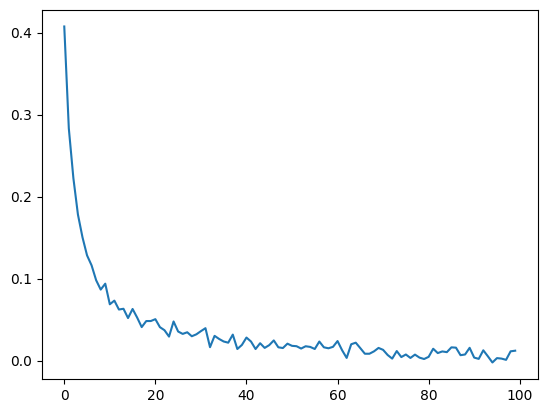

In [254]:
avg_loss = torch.tensor(losses).view(-1, 100).mean(1)
plt.plot(avg_loss)

### Generate some output from the model

In [293]:
idx = torch.eye(1, dtype=torch.long)*torch.tensor(encode(['<|starttext|>']), dtype=torch.long)
print(decode(model8.generate(idx, max_new_tokens=100)[0].tolist()))

['<|starttext|>', 'm', 'a', 'y', 'g', 'e', 'l', 'o', 'r', 'a', '<|endoftext|>']


In [168]:
from IPython.core.display import HTML

def css_styling():
    styles = open("../css/notebook.css", "r").read()
    return HTML(styles)
css_styling()